# Face Mask Detection

### MobileNet | Caffe

In [1]:
import os
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Data Pre-Processing

In [8]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [9]:
DIRECTORY = r"./dataset/"
CATEGORIES = ['with_mask','without_mask']

In [10]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

C:\Users\Arsalan ur Rehman\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## One Hot Encoding - Labels

In [11]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [12]:
labels = to_categorical(labels)

In [13]:
data = np.array(data,dtype='float32')
labels = np.array(labels)

## Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

## Image Data Generator

In [15]:
aug = ImageDataGenerator(rotation_range=20,
                        zoom_range=0.15,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.15,
                        horizontal_flip=True,
                        fill_mode='nearest')

## Load Pre-trained Model (MobileNet)

In [16]:
baseModel = MobileNetV2(weights='imagenet',include_top=False,
                       input_tensor=Input(shape=(224,224,3)))

9412608/9406464 [==============================] - 10s 1us/step


In [17]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [19]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [20]:
for layer in baseModel.layers:
    layer.trainable = False

In [21]:
opt = Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)

In [22]:
model.compile(loss='categorical_crossentropy',
             optimizer=opt,metrics=['accuracy'])

In [23]:
H = model.fit(aug.flow(X_train,y_train,batch_size=BS),
             steps_per_epoch=len(X_train) // BS,
             validation_data=(X_test,y_test),
             validation_steps=len(X_test) // BS,
             epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 114s 1s/step - loss: 0.5867 - accuracy: 0.7075 - val_loss: 0.1017 - val_accuracy: 0.9765
Epoch 2/20
95/95 [==============================] - 98s 1s/step - loss: 0.1455 - accuracy: 0.9520 - val_loss: 0.0613 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 102s 1s/step - loss: 0.1149 - accuracy: 0.9626 - val_loss: 0.0485 - val_accuracy: 0.9857
Epoch 4/20
95/95 [==============================] - 93s 981ms/step - loss: 0.0613 - accuracy: 0.9774 - val_loss: 0.0504 - val_accuracy: 0.9857
Epoch 5/20
95/95 [==============================] - 91s 957ms/step - loss: 0.0600 - accuracy: 0.9800 - val_loss: 0.0383 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 92s 964ms/step - loss: 0.0552 - accuracy: 0.9809 - val_loss: 0.0332 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 92s 969ms/step - loss: 0.0656 - accuracy: 0.9776 - val_loss: 0.0310 - val_accuracy: 0.9909
Epoch 

## Model Evaluation

In [24]:
predIds = model.predict(X_test,batch_size=BS)

In [28]:
predIds = np.argmax(predIds,axis=1)

In [33]:
print(classification_report(y_test.argmax(axis=1),predIds,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



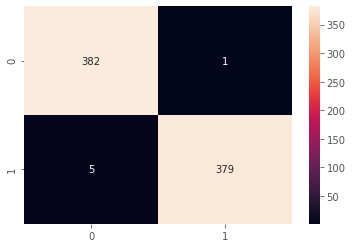

In [41]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test.argmax(axis=1),predIds),annot=True,fmt="d")

## Saving Model

In [39]:
model.save('mask_detector.model',save_format='h5')